## Requirements

Example
- Lets assume you are going to use still photographs comming from a RGB camera.

- You have some **computing power** onboard the device and want to use that to do the processing. No connection to internet. the computing power is equal to a modern phone.

- What sort of **performance** are we after?

- **Data**: how to obtain data, how much and what type?

## Package imports

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

2025-08-26 05:16:50.789163: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 05:16:59.601442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-26 05:17:05.614448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-26 05:17:05.615181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-26 05:17:07.039355: I tensorflow/core/platform/cpu_feature_gua

## Import and preprocess data 

In [2]:
dev_labels = pd.read_csv("../dev_data_2025.csv")
future_labels = pd.read_csv("../future_data_2025.csv")

In [3]:
dev_labels

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole
0,Img_00001,Lymphocyte,round,unsegmented-round,no
1,Img_00002,Monocyte,irregular,unsegmented-indented,no
2,Img_00003,Monocyte,irregular,irregular,yes
3,Img_00004,Basophil,round,segmented-multilobed,no
4,Img_00005,Neutrophil,round,unsegmented-band,no
...,...,...,...,...,...
4995,Img_04996,Lymphocyte,irregular,unsegmented-round,no
4996,Img_04997,Neutrophil,round,unsegmented-band,no
4997,Img_04998,Basophil,round,irregular,no
4998,Img_04999,Neutrophil,round,unsegmented-band,no


In [17]:
# convert to integers while saving the mapping in label_vocab
TARGETS = ["label", "cell_shape", "nucleus_shape", "cytoplasm_vacuole"]
target_vocab = {}
for target in TARGETS:
    dev_labels[target], target_vocab[target] = pd.factorize(dev_labels[target])
dev_labels

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole
0,Img_00001,0,0,0,0
1,Img_00002,1,1,1,0
2,Img_00003,1,1,2,1
3,Img_00004,2,0,3,0
4,Img_00005,3,0,4,0
...,...,...,...,...,...
4995,Img_04996,0,1,0,0
4996,Img_04997,3,0,4,0
4997,Img_04998,2,0,2,0
4998,Img_04999,3,0,4,0


In [22]:
# make train test split
from sklearn.model_selection import train_test_split

train_data_df, test_data_df = train_test_split(dev_labels, test_size=0.2, stratify=dev_labels["label"], random_state=42)
train_data_df, val_data_df = train_test_split(train_data_df, test_size=0.25, stratify=train_data_df["label"], random_state=42)

In [23]:
from pathlib import Path

IMG_DIR = "../Hematoxylin"

def load_image(image_path: str, target_dict: dict):
    full_path = tf.strings.join([IMG_DIR, "/", image_path, ".jpg"])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize(image, [32, 32])

    # one-hot encode each output
    target_onehot_dict = {target: tf.one_hot(vals, len(target_vocab[target])) for target, vals in target_dict.items()}

    return image, target_onehot_dict

def create_tf_dataset_from_df(df: pd.DataFrame):
    ds = tf.data.Dataset.from_tensor_slices((
        df['imageID'].values,
        {target: df[target].values for target in TARGETS},
    ))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)

    return ds

train_dataset = create_tf_dataset_from_df(train_data_df)
val_dataset = create_tf_dataset_from_df(val_data_df)
test_dataset = create_tf_dataset_from_df(test_data_df)

In [24]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_dataset))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(val_dataset)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_dataset))

Number of training samples: 3000
Number of validation samples: 1000
Number of test samples: 1000


**Observation:**
Training is relatively small, which means limited fine tuning of backbone model can be performed later. The training set is not found to be too small for some degree of fine tuning. 

In [25]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_batches = (
    train_dataset
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

validation_batches = (
    val_dataset
    .batch(BATCH_SIZE)
)

test_batches = (
    test_dataset
    .batch(BATCH_SIZE)
)

Print the shapes of the output tensor to check if the dataset generation is working.

In [30]:
for image, targets in train_batches.take(5):
    print(image.shape, [target.shape for _,target in targets.items()])

for image, targets in validation_batches.take(5):
    print(image.shape, [target.shape for _,target in targets.items()])

for image, targets in test_batches.take(5):
    print(image.shape, [target.shape for _,target in targets.items()])


(32, 32, 32, 1) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 1) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 1) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 1) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 1) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 1) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 1) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 1) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 1) [TensorShape([32, 5]), TensorShape([32, 2]), TensorShape([32, 6]), TensorShape([32, 2])]
(32, 32, 32, 1) [TensorShape([32, 5]), TensorShape([32,

2025-08-26 06:23:54.735150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 06:23:54.801830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-26 06:23:54.875235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 32, 32, 1)


2025-08-26 06:35:21.702173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


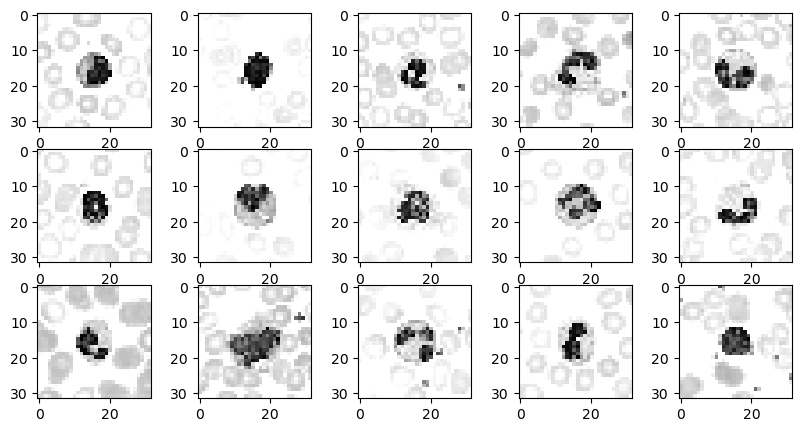

In [33]:
plt.figure(figsize=(10,5))
# clabel = {0: 'right', 1: 'left', 2: 'down', 3: 'up'}
i = 1
for image, targets in train_batches.take(15):
    plt.subplot(3,5,i)
    print(image.shape)
    plt.imshow(image[0,:,:,0], cmap='gray')
    # plt.title(str(clabel[np.argmax(label[0,:])]))
    i = i+1

**Observation:** cells seem to always be in the center and orientation is not important. Hence, tilting with large angles is possible. All examined images seem to representative for the application.

In [ ]:
for image, label in train_dataset:
    print(np.argmax(label['label'].numpy()))

# np.argmax(y[h].numpy(), axis=1)

2025-08-26 06:57:31.999295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


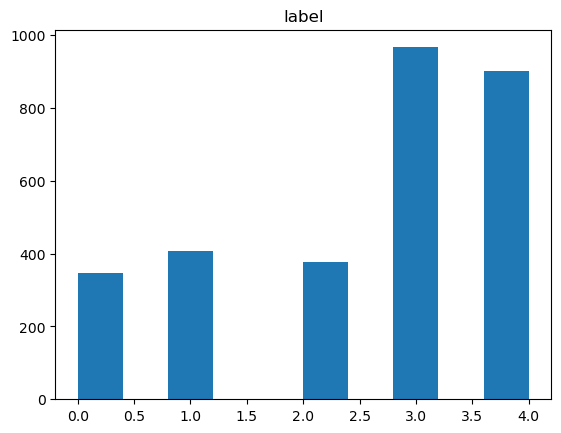

2025-08-26 06:57:33.434326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


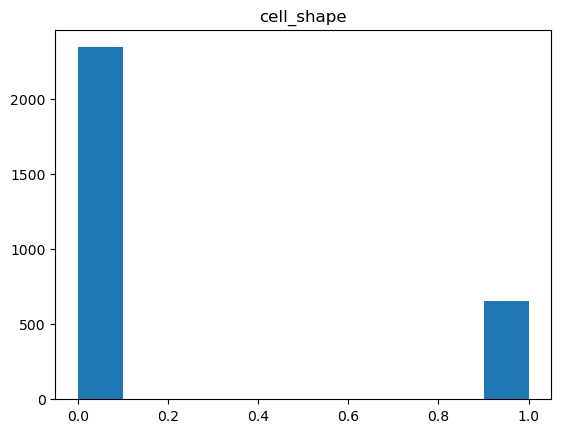

2025-08-26 06:57:34.676508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


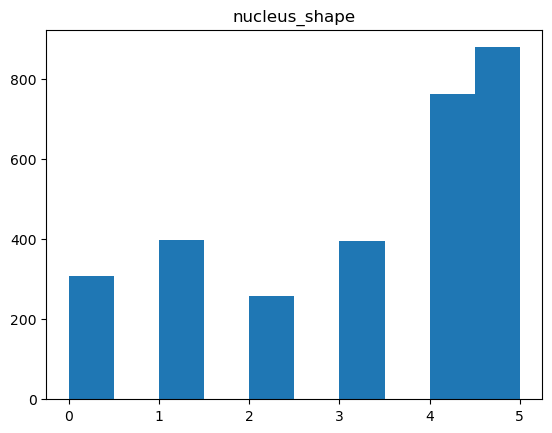

2025-08-26 06:57:35.923042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


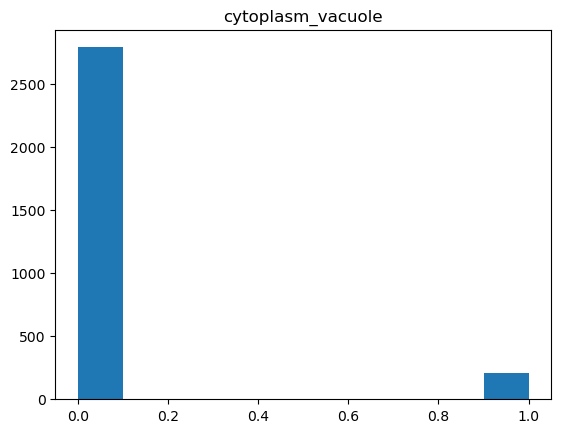

In [43]:
for target in TARGETS:
    train_targets = [int(np.argmax(label[target].numpy())) for image, label in train_dataset]
    plt.hist(train_targets)
    plt.title(target)
    plt.show()

**Observation**: 
- All targets have imbalanced classes and it is especially severe for "cell shape" and "cytoplasm vacuole".
- Because "nucleus shape" has 6 classes, some classes are represented by few training samples.

## Model development

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

def get_model():
  model_cnn = Sequential()

  # input
  model_cnn.add(Input(shape=(32, 32, 1)))

  # Conv Layer 1
  model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
  model_cnn.add(Activation('relu'))
  model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

  # Conv Layer 2 (no pooling)
  model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
  model_cnn.add(Activation('relu'))

  # Conv Layer 3
  model_cnn.add(Conv2D(64, (3, 3)))
  model_cnn.add(Activation('relu'))
  model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

  # MLP
  model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(64))
  model_cnn.add(Activation('relu'))
  #model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(4))
  model_cnn.add(Activation('softmax'))


  return model_cnn

class CNNModel(tf.keras.Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='softmax')
        self.drop = tf.keras.layers.Dropout(0.2)

        self.c1 = Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001))
        
    
    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        x = self.drop(x)
        return self.d2(x)

model = CNNModel()

In [ ]:
model_no_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(10)
])

model_no_aug.compile(
    optimizer = 'adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.losses.SparseCategoricalCrossentropy(from_logits=True, name='SparseCategoricalCrossentropy'), 'accuracy'],
)
m_histories['No_augmentation'] = model_no_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches, verbose=0, callbacks=get_callbacks('models/noAug'))